In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.2 MB/s eta 0:00:00


In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
import time
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as ss
import seaborn as sns
import plotly.express as px
from tqdm.notebook import tqdm
from scipy import stats
from scipy.fft import fft
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.arima_model as old_arima
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.tools import diff
import pmdarima as pm
from scipy.stats import boxcox
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import acf, pacf
from statsmodels.tsa.stattools import acf as acf_values, pacf as pacf_values
np.random.seed(0)

# Data Understanding

In [ ]:
df = pd.read_csv("SPX.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23323 entries, 0 to 23322
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       23323 non-null  object 
 1   Open       23323 non-null  float64
 2   High       23323 non-null  float64
 3   Low        23323 non-null  float64
 4   Close      23323 non-null  float64
 5   Adj Close  23323 non-null  float64
 6   Volume     23323 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.2+ MB


In [ ]:
df = df[["Date", "Close"]]
df["Date"] = pd.to_datetime(df["Date"])

<ipython-input-5-939a8e25e331>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


In [ ]:
df.info(), df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23323 entries, 0 to 23322
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    23323 non-null  datetime64[ns]
 1   Close   23323 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 364.5 KB


(None,
         Date      Close
 0 1927-12-30  17.660000
 1 1928-01-03  17.760000
 2 1928-01-04  17.719999
 3 1928-01-05  17.549999
 4 1928-01-06  17.660000
 5 1928-01-09  17.500000
 6 1928-01-10  17.370001
 7 1928-01-11  17.350000
 8 1928-01-12  17.469999
 9 1928-01-13  17.580000)

In [ ]:
px.line(df, "Date", "Close")

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


In [ ]:
## Locate where date in the earliest 2016
df[df["Date"]=="2016-01-04"]


,Date,Close
22103,2016-01-04,2012.660034


In [ ]:
## Truncate to that date
df = df[22103:].reset_index(drop=True)

In [ ]:
px.line(df, "Date", "Close")

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
# Split data for 3 months of outsample
df[df["Date"]=="2020-07-01"]

,Date,Close
1131,2020-07-01,3115.860107


In [ ]:
df_insample = df[:1131]
df_outsample = df[1131:]

In [ ]:
df_insample.info(),
df_outsample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1131 non-null   datetime64[ns]
 1   Close   1131 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 1131 to 1219
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    89 non-null     datetime64[ns]
 1   Close   89 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.5 KB


In [ ]:
df_insample['Type'] = 'In-sample'
df_outsample['Type'] = 'Out-sample'
df_combined = pd.concat([df_insample, df_outsample])


px.line(df_combined, x="Date", y="Close", color='Type',
        title="In-sample vs Out-sample Close Prices")


<ipython-input-14-e009044160e1>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-e009044160e1>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



# ARIMA

## Determine Stationarity and p,d,q orders

### In Variance Stationarity

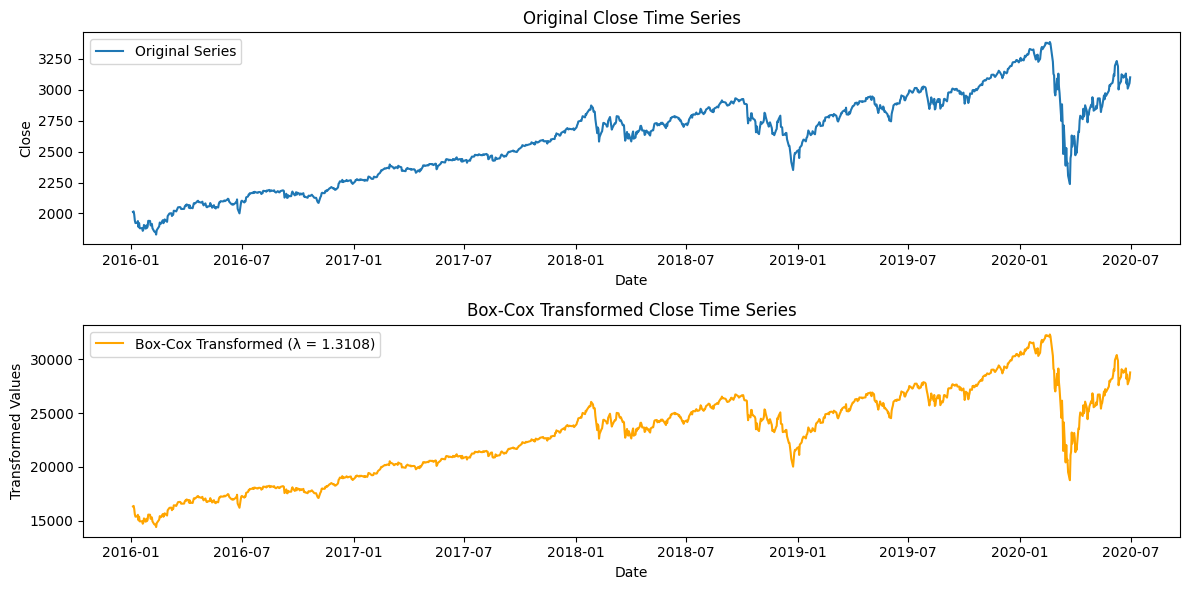

In [ ]:
def box_cox_transformation(df, column):
    """
    Perform Box-Cox transformation and visualize the results.

    Parameters:
    df (pd.DataFrame): Input dataframe containing the time series data.
    column (str): The column name of the time series data to be transformed.

    Returns:
    transformed_series (pd.Series): The Box-Cox transformed time series.
    lambda_bc (float): The lambda value used in the Box-Cox transformation.
    """

    if (df[column] <= 0).any():
        df[column] += abs(df[column].min()) + 1

    transformed_series, lambda_bc = boxcox(df[column])

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(df['Date'], df[column], label='Original Series')
    plt.title(f"Original {column} Time Series")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(df['Date'], transformed_series, label=f'Box-Cox Transformed (λ = {lambda_bc:.4f})', color='orange')
    plt.title(f"Box-Cox Transformed {column} Time Series")
    plt.xlabel("Date")
    plt.ylabel("Transformed Values")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return transformed_series, lambda_bc

transformed_series_insample, lambda_bc = box_cox_transformation(df_insample, column='Close')

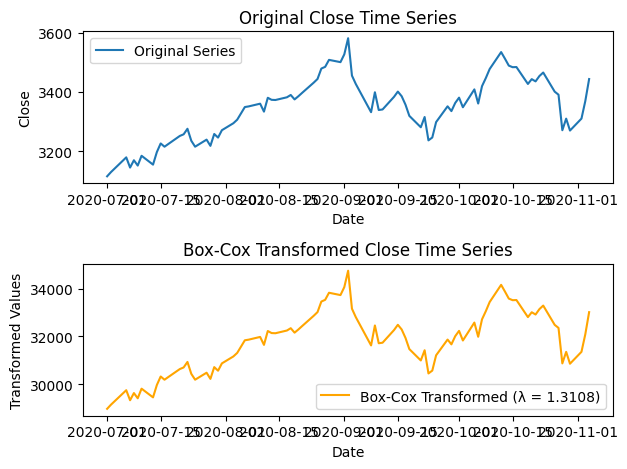

In [ ]:
## Dont forget to transform the outsample as well

def box_cox(df, column, lambda_bc):
    transformed_series = stats.boxcox(df[column], lmbda = lambda_bc)

    plt.subplot(2, 1, 1)
    plt.plot(df['Date'], df[column], label='Original Series')
    plt.title(f"Original {column} Time Series")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(df['Date'], transformed_series, label=f'Box-Cox Transformed (λ = {lambda_bc:.4f})', color='orange')
    plt.title(f"Box-Cox Transformed {column} Time Series")
    plt.xlabel("Date")
    plt.ylabel("Transformed Values")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return transformed_series

transformed_series_outsample = box_cox(df_outsample, "Close", lambda_bc)

In [ ]:
## Put transformed data in dataframe
df_insample["Close"] = transformed_series_insample
df_outsample["Close"] = transformed_series_outsample

<ipython-input-17-d16b87c97d29>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-17-d16b87c97d29>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### To Check in Mean Stationarity

<Figure size 1000x500 with 0 Axes>

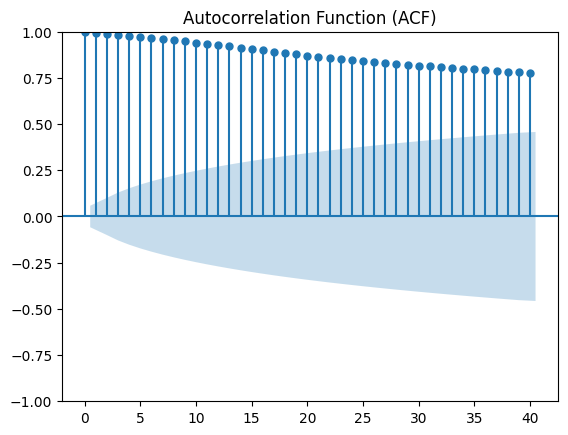

<Figure size 1000x500 with 0 Axes>

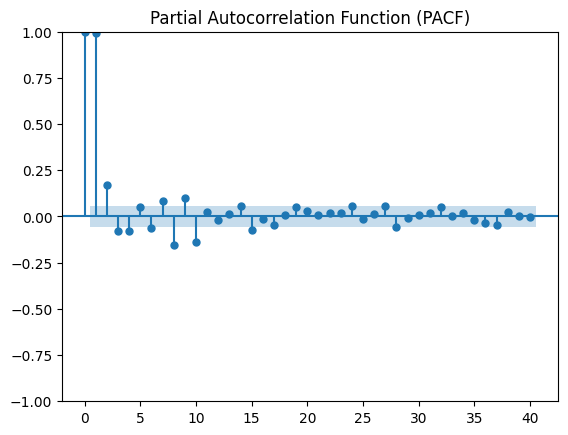

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plot
plt.figure(figsize=(10, 5))
plot_acf(df_insample['Close'], lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF plot
plt.figure(figsize=(10, 5))
plot_pacf(df_insample['Close'], lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

## As shown, data is not in stationary in mean

In [ ]:
def adftest(series, plots=True):
    out = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")

    if plots:
        # Compute rolling statistics
        rolmean = series.rolling(window=12).mean()
        rolstd = series.rolling(window=12).std()

        # Plot rolling statistics:
        plt.figure(figsize=(14, 4))
        plt.plot(series, color='tab:blue',label='Original')
        plt.plot(rolmean, color='tab:red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.grid();

ADF Statistic: -1.95
p-value: 0.309
Critical Values: ['1%: -3.44', '5%: -2.86', '10%: -2.57']



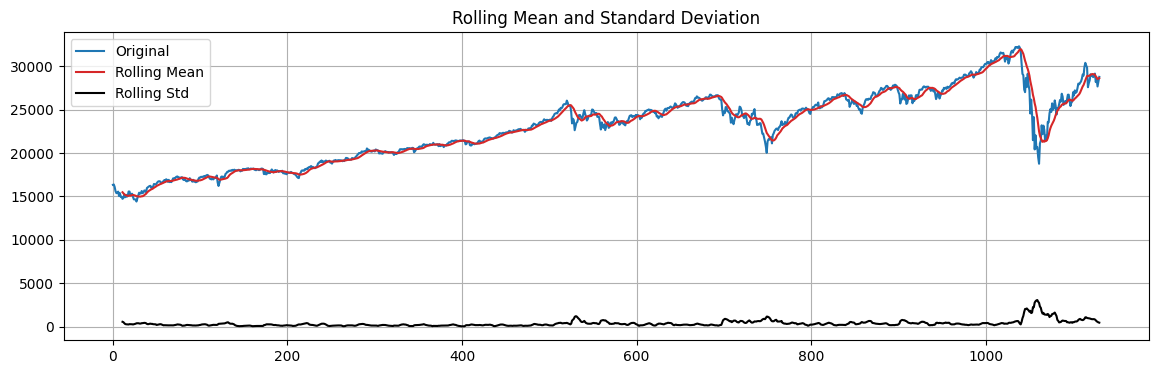

In [ ]:
adftest(df_insample["Close"])
## ADF test shows that it does not follow unit root i.e. not stationary in mean

In [ ]:
def check_stationarity(df, column, diff_order=1):
    """
    Parameters:
    1. df (pd.DataFrame): The input dataframe containing the time series data.
    2. column (str): The column name of the time series data to be tested.
    3. diff_order (int): The order of differencing to apply.
    """

    diff_series = df[column].diff(periods=diff_order).dropna()

    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'], df[column], label=f'Original {column}')
    plt.plot(df['Date'][diff_order:], diff_series, label=f'Differenced (Order {diff_order}) {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.title(f"Original vs Differenced (Order {diff_order}) Time Series")
    plt.show()

    adf_result = adfuller(diff_series)

    print("ADF Test Results:")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value}")

    if adf_result[1] < 0.05:
        print("The series is likely stationary (Reject H0)")
        return diff_series
    else:
        print("The series is likely non-stationary (Fail to reject H0)")




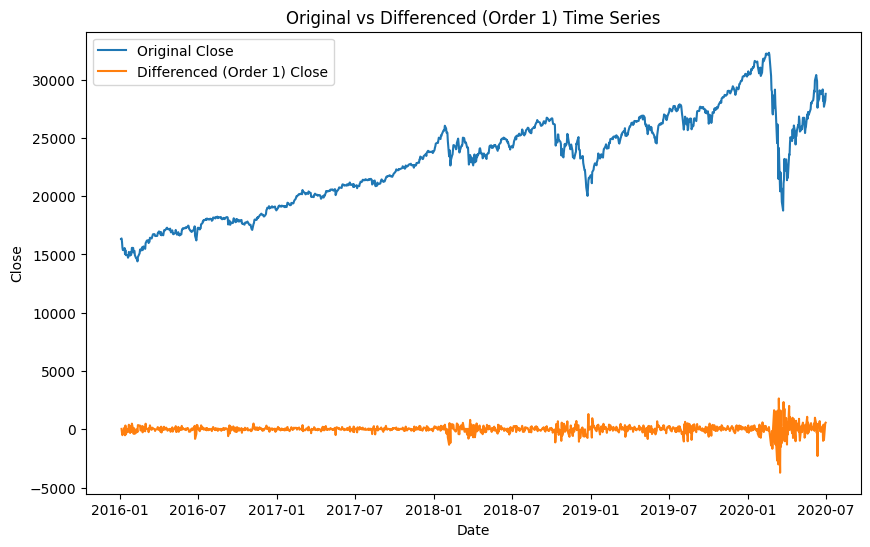

ADF Test Results:
ADF Statistic: -9.696231654295625
p-value: 1.1024846033406938e-16
Critical Values:
   1%: -3.436196866494929
   5%: -2.864121720649023
   10%: -2.568144581443706
The series is likely stationary (Reject H0)


In [ ]:
temp = check_stationarity(df_insample, "Close", diff_order=1)

In [ ]:
len(temp), df_insample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1131 non-null   datetime64[ns]
 1   Close   1131 non-null   float64       
 2   Type    1131 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 26.6+ KB


(1130, None)

### p,d,q Orders Identification

<Figure size 1000x500 with 0 Axes>

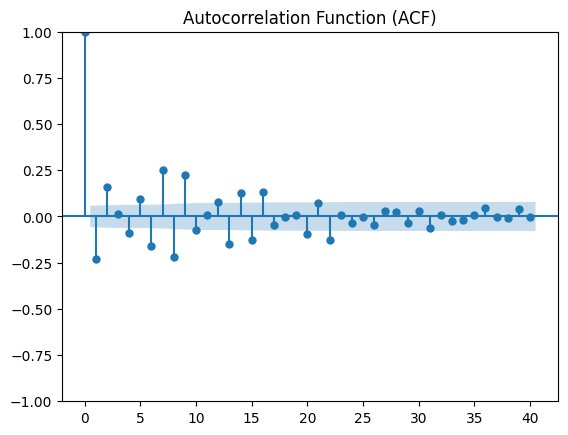

<Figure size 1000x500 with 0 Axes>

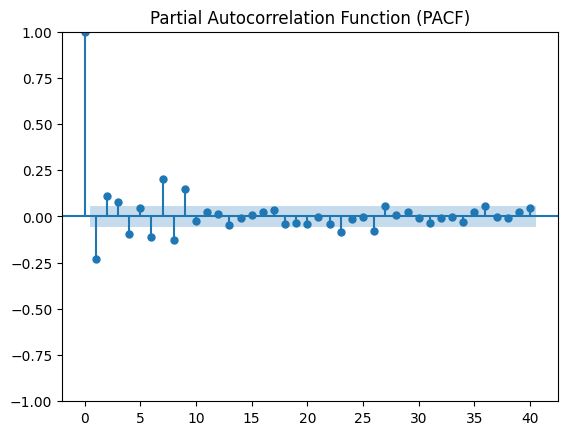

In [ ]:
# ACF plot
plt.figure(figsize=(10, 5))
plot_acf(temp, lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF plot
plt.figure(figsize=(10, 5))
plot_pacf(temp, lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

## As shown, data is probably in a stationary mode

Based on PACF and ACF, possible params includes:
$$p: 1, 2, 3, 4, 6, 7, 8, 9$$
$$q: 1, 2, 4, 6, 7, 8, 9$$
with $d=1$, the possible combination for ARIMA models are:
1. [1, 1, 1]
2. [1, 1, 2]
3. [1, 1, 4]
4. [1, 1, 6]
5. [1, 1, 7]
6. [1, 1, 8]
7. [1, 1, 9]
8. [2, 1, 1]
9. [2, 1, 2]
10. [2, 1, 4]
11. [2, 1, 6]
12. [2, 1, 7]
13. [2, 1, 8]
14. [2, 1, 9]
15. [3, 1, 1]
16. [3, 1, 2]
17. [3, 1, 4]
18. [3, 1, 6]
19. [3, 1, 7]
20. [3, 1, 8]
21. [3, 1, 9]
22. [4, 1, 1]
23. [4, 1, 2]
24. [4, 1, 4]
25. [4, 1, 6]
26. [4, 1, 7]
27. [4, 1, 8]
28. [4, 1, 9]
29. [6, 1, 1]
30. [6, 1, 2]
31. [6, 1, 4]
32. [6, 1, 6]
33. [6, 1, 7]
34. [6, 1, 8]
35. [6, 1, 9]
36. [7, 1, 1]
37. [7, 1, 2]
38. [7, 1, 4]
39. [7, 1, 6]
40. [7, 1, 7]
41. [7, 1, 8]
42. [7, 1, 9]
43. [8, 1, 1]
44. [8, 1, 2]
45. [8, 1, 4]
46. [8, 1, 6]
47. [8, 1, 7]
48. [8, 1, 8]
49. [8, 1, 9]
50. [9, 1, 1]
51. [9, 1, 2]
52. [9, 1, 4]
53. [9, 1, 6]
54. [9, 1, 7]
55. [9, 1, 8]
56. [9, 1, 9]

In [ ]:
pdq_combinations = [
    (1, 1, 1),
(1, 1, 2),
(1, 1, 4),
(1, 1, 6),
(1, 1, 7),
(1, 1, 8),
(1, 1, 9),
(2, 1, 1),
(2, 1, 2),
(2, 1, 4),
(2, 1, 6),
(2, 1, 7),
(2, 1, 8),
(2, 1, 9),
(3, 1, 1),
(3, 1, 2),
(3, 1, 4),
(3, 1, 6),
(3, 1, 7),
(3, 1, 8),
(3, 1, 9),
(4, 1, 1),
(4, 1, 2),
(4, 1, 4),
(4, 1, 6),
(4, 1, 7),
(4, 1, 8),
(4, 1, 9),
(6, 1, 1),
(6, 1, 2),
(6, 1, 4),
(6, 1, 6),
(6, 1, 7),
(6, 1, 8),
(6, 1, 9),
(7, 1, 1),
(7, 1, 2),
(7, 1, 4),
(7, 1, 6),
(7, 1, 7),
(7, 1, 8),
(7, 1, 9),
(8, 1, 1),
(8, 1, 2),
(8, 1, 4),
(8, 1, 6),
(8, 1, 7),
(8, 1, 8),
(8, 1, 9),
(9, 1, 1),
(9, 1, 2),
(9, 1, 4),
(9, 1, 6),
(9, 1, 7),
(9, 1, 8),
(9, 1, 9)
]

### AutoARIMA Modelling

In [ ]:
model = pm.auto_arima(
    y=df_insample["Close"],
    start_p=0,
    start_q=0,
    max_p=9,
    max_d=1,
    max_q=9,
    seasonal=False,
    m=1,
    stepwise=False,
    suppress_warnings=True,
    information_criterion='aic',
    n_jobs=-1,
    trace=True,
    order=None,
    scoring='mse',
    error_action='ignore',
    with_intercept="auto",
    max_order=None,
    grid_search_kwargs={
        "orders": pdq_combinations
    }
)



Best model:  ARIMA(4,1,8)(0,0,0)[0] intercept
Total fit time: 191.889 seconds


In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1131
Model:               SARIMAX(4, 1, 8)   Log Likelihood               -8216.067
Date:                Sun, 22 Sep 2024   AIC                          16460.134
Time:                        14:18:20   BIC                          16530.553
Sample:                             0   HQIC                         16486.739
                               - 1131                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     13.3393     16.322      0.817      0.414     -18.651      45.330
ar.L1         -0.0572      0.035     -1.653      0.098      -0.125       0.011
ar.L2          0.7871      0.031     25.739      0.000       0.727       0.847
ar.L3         -0.2225      0.030     -7.362      0.000      -0.282      -0.163
ar.L4         -0.7957      0.029    -27.914      0.000      -0.852      -0.740
ma.L1         -0.0659      0.037     -1.785      0.074      -0.138       0.006
ma.L2         -0.7070      0.034    -20.845      0.000      -0.773      -0.641
ma.L3          0.3739      0.034     10.944      0.000       0.307       0.441
ma.L4          0.6150      0.032     19.287      0.000       0.553       0.678
ma.L5         -0.0754      0.021     -3.598      0.000      -0.116      -0.034
ma.L6          0.0654      0.020      3.293      0.001       0.026       0.104
ma.L7          0.1715      0.019      9.179      0.000       0.135       0.208
ma.L8         -0.1172      0.025     -4.728      0.000      -0.166      -0.069
sigma2      1.226e+05   2203.307     55.644      0.000    1.18e+05    1.27e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):              9442.74
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               8.09   Skew:                            -1.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
forecast_steps = 89
forecast, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)


In [ ]:
df_insample.tail()

,Date,Close,Type
1126,2020-06-24,28167.541387,In-sample
1127,2020-06-25,28572.886161,In-sample
1128,2020-06-26,27668.915604,In-sample
1129,2020-06-29,28202.770047,In-sample
1130,2020-06-30,28773.822261,In-sample


In [ ]:
forecast

,0
1131,28739.272982
1132,28962.502832
1133,28712.922932
1134,28809.469835
1135,28467.003511
...,...
1215,29542.906045
1216,29548.145997
1217,29561.137976
1218,29580.717602


In [ ]:
df_outsample["Close"]

,Close
1131,28963.394054
1132,29135.930366
1133,29743.985090
1134,29322.886206
1135,29624.120234
...,...
1215,31352.916441
1216,30855.351761
1217,31354.529087
1218,32088.107146


In [ ]:
forecast_index = pd.date_range(start=df_insample['Date'].iloc[-1], periods=forecast_steps+1, freq='D')[1:]
df_forecast = pd.DataFrame({'Date': forecast_index, 'Forecast': forecast})

# Merge forecast with actual out-sample data
df_compare = pd.merge(df_outsample.head(forecast_steps), df_forecast, on='Date')

# Calculate RMSE to evaluate the forecast
rmse = mean_squared_error(df_compare['Close'], df_compare['Forecast'], squared=False)
print(f"RMSE: {rmse}")

# Plot actual vs forecasted
fig = px.line(df_compare, x='Date', y=['Close', 'Forecast'], title="Actual vs Forecasted Close Price")
fig.show()

RMSE: 2600.5266471990694


/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



# SARIMA

In [ ]:
modelsarima = pm.auto_arima(
    y=df_insample["Close"],  # Replace with your time series data
    start_p=0,
    start_q=0,
    max_p=9,
    max_d=1,
    max_q=9,
    seasonal=True,           # Set to True if you have seasonal data
    m=5,                      # Set the seasonality (m=1 for non-seasonal)
    stepwise=False,           # Disable stepwise model selection
    suppress_warnings=True,
    information_criterion='aic',  # Criterion to minimize (e.g., AIC, BIC)
    n_jobs=-1,                # Use multiple cores for faster computation
    trace=True,               # Enable this to print the fitting process
    order=None,               # Will search over pdq combinations explicitly
    scoring='mse',            # Metric to use for evaluating models
    error_action='ignore',    # Skip models that cause errors
    with_intercept="auto",    # Add intercept if applicable
    max_order=None,           # Limit the total order of p, d, q
    grid_search_kwargs={
        "orders": pdq_combinations  # Supply pdq combinations directly
    }
)



Best model:  ARIMA(4,1,3)(1,0,0)[5] intercept
Total fit time: 373.053 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1130
Model:             SARIMAX(4, 1, 3)x(1, 0, [], 5)   Log Likelihood               -8213.922
Date:                            Sun, 22 Sep 2024   AIC                          16445.843
Time:                                    14:24:36   BIC                          16491.105
Sample:                                         0   HQIC                         16462.944
                                           - 1130                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8816      0.097     -9.106      0.000      -1.071      -0.692
ar.L2          0.5949      0.127   

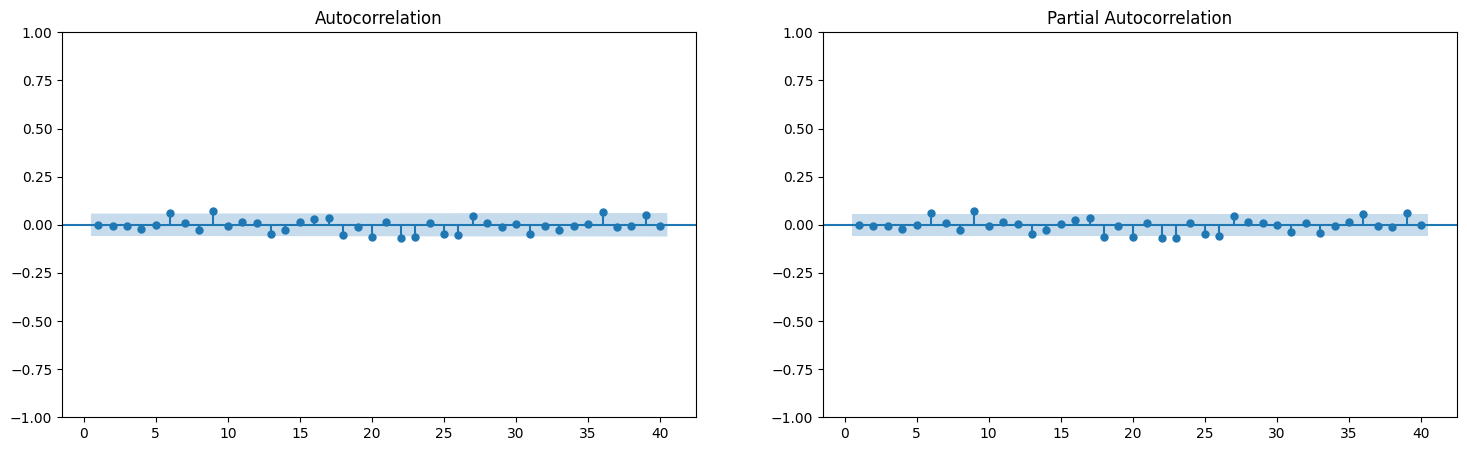

In [ ]:
# Importing Required Packages
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as sgt

# Assuming df_insample is defined and has a "Close" column

# Defining the Model
seas_model = SARIMAX(df_insample["Close"][1:], order=(4, 1, 3), seasonal_order=(1, 0, 0, 5))
# Fitting the Model
seas_model_results = seas_model.fit()

# Printing the model summary
print(seas_model_results.summary())


# EVALUATING RESIDUALS
# Defining the figure size
plt.rcParams["figure.figsize"] = (18, 5)

# Defining the subplots
fig, axes = plt.subplots(1, 2)

# ACF and PACF for residuals of SARIMA(4, 1, 3)(1, 0, 0, 5)
sgt.plot_acf(seas_model_results.resid[1:], zero=False, lags=40, ax=axes[0])
sgt.plot_pacf(seas_model_results.resid[1:], zero=False, lags=40, ax=axes[1])

# Displaying the plots
plt.show()


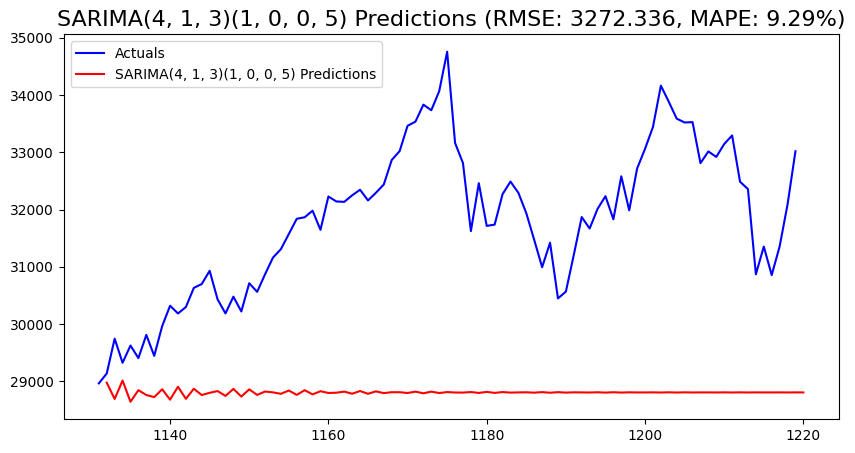

In [ ]:
# Importing Required Packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Forecasts of SARIMA model on out-of-sample data
seas_pred_outsample = seas_model_results.predict(start=df_outsample.index[0], end=df_outsample.index[-1])

# RMSE of SARIMA model on out-of-sample data
sarima_rmse_outsample = np.sqrt(mean_squared_error(y_true=df_outsample["Close"].values, y_pred=seas_pred_outsample))

# MAPE of SARIMA model on out-of-sample data
sarima_mape_outsample = mean_absolute_percentage_error(y_true=df_outsample["Close"].values, y_pred=seas_pred_outsample)

# FORECAST vs ACTUALS PLOT for Out-of-Sample Data
plt.rcParams["figure.figsize"] = 10, 5  # Adjusted figure size for one plot

# Plotting Actuals vs Predictions for SARIMA model
plt.plot(df_outsample["Close"], color="blue", label="Actuals")
plt.plot(seas_pred_outsample, color="red", label="SARIMA(4, 1, 3)(1, 0, 0, 5) Predictions")
plt.title(f"SARIMA(4, 1, 3)(1, 0, 0, 5) Predictions (RMSE: {np.round(sarima_rmse_outsample, 3)}, MAPE: {np.round(sarima_mape_outsample, 2)}%)", size=16)
plt.legend()

# Displaying the plot
plt.show()


# GARCH

# Prophet

# Best of All